In [1]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

In [2]:
def generate_linear_data() -> Tuple[np.ndarray, np.ndarray]:
    """ Generate random linear data to test our Kalman Filter implementation.
    """
    x = np.linspace(0, 10, 100)
    y = 1.8 * x -3.21 + np.random.normal(0, 1, size=x.shape)
    return x, y

def generate_quad_data() -> Tuple[np.ndarray, np.ndarray]:
    """ Generate random quadratic data to test our Kalman Filter implementation.
    """
    x = np.linspace(0, 10, 100)
    y = 1.8 * x - 0.7 * x**2 - 3.21 + np.random.normal(0, 2, size=x.shape)
    return x, y

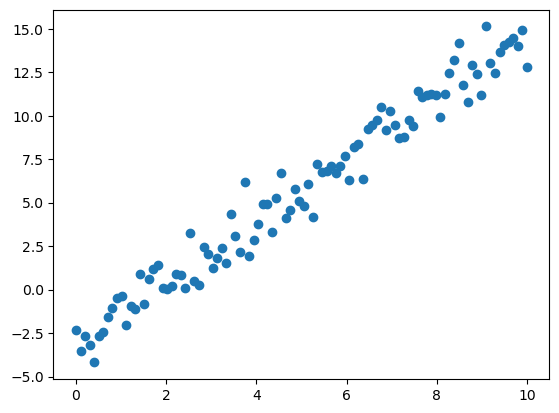

In [3]:
xl, yl = generate_linear_data()

plt.scatter(xl, yl);

## <font color='cornflowerblue'> Linear Regression

In [4]:
W = np.array([1, 1]) # mx + b
